In [ ]:
#Download connll no alt
#SAX parsing
#https://docs.python.org/2/library/xml.sax.html
#https://wiki.python.org/moin/Sax

In [ ]:
#read conll corpus
#cumpare anotators

In [1]:
import xml.sax
class InkscapeSvgHandler(xml.sax.ContentHandler):
    def __init__(self, teacher_id):
        self.teacher_id=teacher_id
        
    def startDocument(self):
        self.parsed_data=[]
        
    def startElement(self, name, attrs):
        self.tag = name
        if name == "MISTAKE":
            self.current_mistake={}
            for (k,v) in attrs.items():
                self.current_mistake[k]=v
            self.current_mistake['teacher_id']=self.teacher_id
            
    def characters(self, content):
        if self.tag=='TYPE':
            self.current_mistake['type']=content
            self.tag=''
        if self.tag=='CORRECTION':
            self.current_mistake['correction']=content
            self.tag=''
        
    def endElement (self, name):
        if name == "MISTAKE":
            self.parsed_data.append(self.current_mistake)
            
class HubErrorHandler(xml.sax.ErrorHandler):
    def __init__(self):
        pass
    def error(self, exception):
        import sys
        print ("Error, exception: %s\n" % exception)
    def fatalError(self, exception):
        print ("Fatal Error, exception: %s\n" % exception)

parser = xml.sax.make_parser()
content_parser_8= InkscapeSvgHandler(8)
parser.setContentHandler(content_parser_8)
parser.setErrorHandler(HubErrorHandler())
parser.parse(open("conll/noalt/official-2014.0.conll.ann","r"))
content_parser_9= InkscapeSvgHandler(9)
parser.setContentHandler(content_parser_9)
parser.parse(open("conll/noalt/official-2014.1.conll.ann","r"))
results = content_parser_8.parsed_data + content_parser_9.parsed_data

In [2]:
import pandas as pd
df = pd.DataFrame(columns=['teacher_id','type','correction','nid','pid','sid','start_token','end_token'], data=results)

In [3]:
df.to_csv('erors.csv',encoding='utf8', index=False)

In [28]:
df['chars']=df.apply(lambda row: set(range(int(row['start_token'])-1, int(row['end_token']))), axis=1)

In [29]:
df.head()

,teacher_id,type,correction,nid,pid,sid,start_token,end_token,chars
0,8,ArtOrDet,\n,1,1,1,3,4,"{2, 3}"
1,8,Nn,diseases,1,1,2,3,4,"{2, 3}"
2,8,Trans,",",1,1,7,1,1,{0}
3,8,Mec,diagnosed,1,1,8,3,4,"{2, 3}"
4,8,Prep,\n,1,1,8,4,5,"{3, 4}"


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5708 entries, 0 to 5707
Data columns (total 9 columns):
teacher_id     5708 non-null int64
type           5708 non-null object
correction     5708 non-null object
nid            5708 non-null object
pid            5708 non-null object
sid            5708 non-null object
start_token    5708 non-null object
end_token      5708 non-null object
chars          5708 non-null object
dtypes: int64(1), object(8)
memory usage: 401.4+ KB


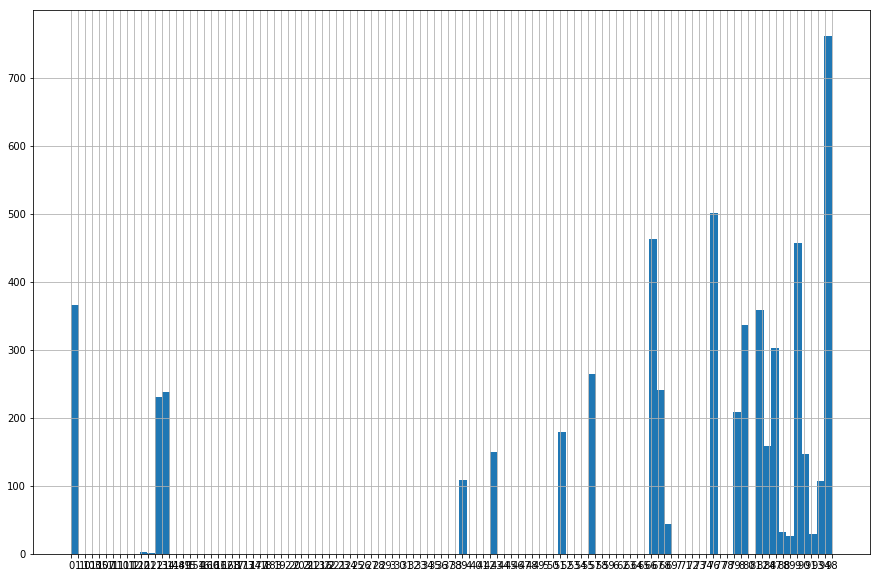

In [12]:
%matplotlib inline
df['start_token'].hist(figsize=(15,10), bins=100)

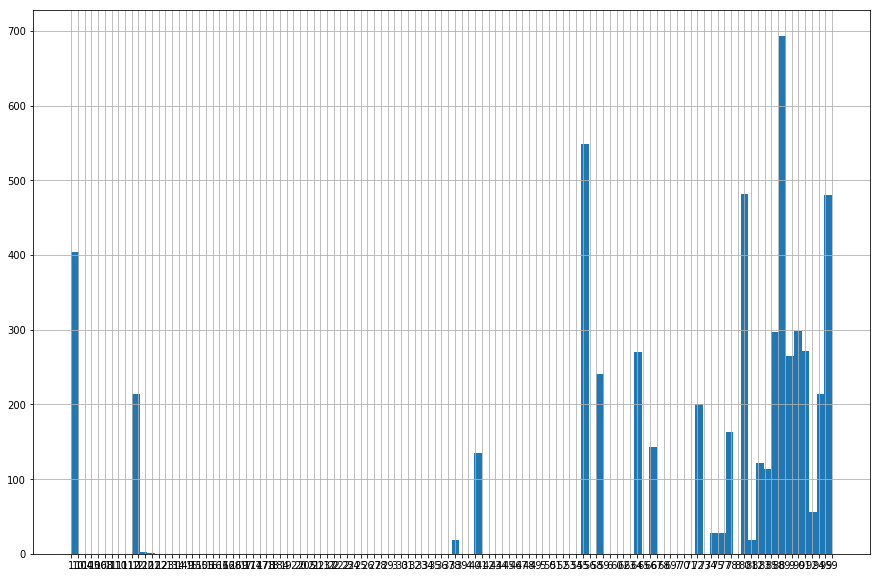

In [13]:
df['end_token'].hist(figsize=(15,10), bins=100)

In [16]:
df['type'].value_counts()

Wci         819
ArtOrDet    774
Mec         721
Prep        601
Nn          443
Rloc-       293
Vt          283
SVA         259
Pref        249
Vform       223
Wform       180
Trans       171
Others       93
Vm           86
Ssub         78
WOinc        76
V0           68
Pform        65
Um           54
WOadv        39
Npos         34
Srun         28
Spar         27
Wtone        24
Sfrag        14
Smod          5
Wa            1
Name: type, dtype: int64

In [15]:
df[df['teacher_id']==9]['type'].value_counts()

Mec         493
Wci         479
ArtOrDet    443
Prep        390
Nn          228
Rloc-       199
SVA         154
Pref        153
Vt          150
Wform       103
Vform        91
Trans        78
WOinc        54
Others       49
Um           42
V0           37
Vm           37
WOadv        27
Spar         24
Srun         21
Pform        18
Npos         15
Wtone        15
Ssub         10
Smod          5
Sfrag         1
Wa            1
Name: type, dtype: int64

In [17]:
df['correction'].value_counts()

\n                                    1046
,                                      265
a                                      191
the                                    138
to                                      78
are                                     78
their                                   71
of                                      71
in                                      54
is                                      51
about                                   47
have                                    47
on                                      45
for                                     45
they                                    44
and                                     38
with                                    36
lives                                   34
.                                       30
that                                    27
them                                    27
be                                      27
relationships                           25
an         

In [14]:
df[df['teacher_id']==8]['type'].value_counts()

Wci         340
ArtOrDet    331
Mec         228
Nn          215
Prep        211
Vt          133
Vform       132
SVA         105
Pref         96
Rloc-        94
Trans        93
Wform        77
Ssub         68
Vm           49
Pform        47
Others       44
V0           31
WOinc        22
Npos         19
Sfrag        13
WOadv        12
Um           12
Wtone         9
Srun          7
Spar          3
Name: type, dtype: int64

In [31]:
# find same errors
grouped_mistakes={}
for key, values in df.groupby(['nid','pid','sid']):
    grouped_mistakes[key]=values

In [34]:
paragraph_errors=grouped_mistakes[('1', '1', '1')]
paragraph_errors

,teacher_id,type,correction,nid,pid,sid,start_token,end_token,chars
0,8,ArtOrDet,\n,1,1,1,3,4,"{2, 3}"
2391,9,Rloc-,\n,1,1,1,3,4,"{2, 3}"


In [33]:
#Get sets intersections:
#if sets equal - good
# if intersect and teacher id is different -> add ass error

In [69]:
def compare_sets(set1,set2):
    intersection = set1.intersection(set2)
    if len(intersection)==0:
        return True
    return (len(intersection)==len(set1)) and (len(intersection)==len(set2))

def compare_types(type1,type2):
    return type1==type2

In [66]:
def get_error_details(data):
    return {'teacher_id' : data['teacher_id'],'type':data['type'],'correction':data['correction'],'chars':data['chars']}

In [70]:
def find_annotattion_errors(paragraph_errors):
    paragraph_errors_8=paragraph_errors[paragraph_errors['teacher_id']==8]
    paragraph_errors_8
    
    paragraph_errors_9=paragraph_errors[paragraph_errors['teacher_id']==9]
    paragraph_errors_9
    
    diff=[]
    for index_e8, e8 in paragraph_errors_8.iterrows():
        for index_e9, e9 in paragraph_errors_9.iterrows():
            if(compare_types(e8['type'],e9['type'])==False):
                diff.append(('type_error',get_error_details(e8),get_error_details(e9)))
            if(compare_sets(e8['chars'],e9['chars'])==False):
                diff.append(('sets_error',get_error_details(e8),get_error_details(e9)))
            
    return diff

In [45]:
diff=[]
for i, e8 in enumerate(paragraph_errors_8):
    for j, e9 in enumerate(paragraph_errors_9):
        cimpare results = compare_sets(e8,e9)
        diff.append()

In [71]:
grouped_mistakes={}
for key, values in df.groupby(['nid','pid','sid']):
    grouped_mistakes[key]=find_annotattion_errors(values)
    if len(grouped_mistakes[key])>0:
        print(key)
        print(grouped_mistakes[key])

('1', '1', '1')
[('type_error', {'teacher_id': 8, 'type': 'ArtOrDet', 'correction': '\n', 'chars': {2, 3}}, {'teacher_id': 9, 'type': 'Rloc-', 'correction': '\n', 'chars': {2, 3}})]
('1', '1', '7')
[('type_error', {'teacher_id': 8, 'type': 'Trans', 'correction': ',', 'chars': {0}}, {'teacher_id': 9, 'type': 'Mec', 'correction': ',', 'chars': {0}})]
('1', '1', '8')
[('type_error', {'teacher_id': 8, 'type': 'Mec', 'correction': 'diagnosed', 'chars': {2, 3}}, {'teacher_id': 9, 'type': 'Rloc-', 'correction': 'diagnosed', 'chars': {2, 3, 4}}), ('sets_error', {'teacher_id': 8, 'type': 'Mec', 'correction': 'diagnosed', 'chars': {2, 3}}, {'teacher_id': 9, 'type': 'Rloc-', 'correction': 'diagnosed', 'chars': {2, 3, 4}}), ('type_error', {'teacher_id': 8, 'type': 'Mec', 'correction': 'diagnosed', 'chars': {2, 3}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': 'a', 'chars': {5}}), ('type_error', {'teacher_id': 8, 'type': 'Mec', 'correction': 'diagnosed', 'chars': {2, 3}}, {'teacher_id': 9, '

('12', '1', '3')
[('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'cause', 'chars': {13, 14}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': '\n', 'chars': {3, 4}}), ('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'cause', 'chars': {13, 14}}, {'teacher_id': 9, 'type': 'Prep', 'correction': 'against', 'chars': {17}}), ('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'cause', 'chars': {13, 14}}, {'teacher_id': 9, 'type': 'Um', 'correction': '\n', 'chars': {18, 19}}), ('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'cause', 'chars': {13, 14}}, {'teacher_id': 9, 'type': 'Mec', 'correction': ',', 'chars': {21}}), ('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'cause', 'chars': {13, 14}}, {'teacher_id': 9, 'type': 'SVA', 'correction': 'are', 'chars': {22, 23}}), ('type_error', {'teacher_id': 8, 'type': 'Vform', 'correction': 'to', 'chars': {15}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': '\n', 'chars': {3, 

[('type_error', {'teacher_id': 8, 'type': 'Vt', 'correction': 'shows', 'chars': {8, 7}}, {'teacher_id': 9, 'type': 'Prep', 'correction': 'by', 'chars': {1, 2}}), ('type_error', {'teacher_id': 8, 'type': 'Vt', 'correction': 'shows', 'chars': {8, 7}}, {'teacher_id': 9, 'type': 'SVA', 'correction': 'recover', 'chars': {16, 15}}), ('type_error', {'teacher_id': 8, 'type': 'Vt', 'correction': 'shows', 'chars': {8, 7}}, {'teacher_id': 9, 'type': 'Prep', 'correction': 'of', 'chars': {23}}), ('type_error', {'teacher_id': 8, 'type': 'SVA', 'correction': 'recover', 'chars': {16, 15}}, {'teacher_id': 9, 'type': 'Prep', 'correction': 'by', 'chars': {1, 2}}), ('type_error', {'teacher_id': 8, 'type': 'SVA', 'correction': 'recover', 'chars': {16, 15}}, {'teacher_id': 9, 'type': 'Vt', 'correction': 'showed', 'chars': {8, 7}}), ('type_error', {'teacher_id': 8, 'type': 'SVA', 'correction': 'recover', 'chars': {16, 15}}, {'teacher_id': 9, 'type': 'Prep', 'correction': 'of', 'chars': {23}}), ('type_error',

[('type_error', {'teacher_id': 8, 'type': 'Pref', 'correction': ', they', 'chars': {0, -1}}, {'teacher_id': 9, 'type': 'Rloc-', 'correction': '\n', 'chars': {6, 7}}), ('type_error', {'teacher_id': 8, 'type': 'Pref', 'correction': ', they', 'chars': {0, -1}}, {'teacher_id': 9, 'type': 'SVA', 'correction': 'improves', 'chars': {8, 9}}), ('type_error', {'teacher_id': 8, 'type': 'Pref', 'correction': ', they', 'chars': {0, -1}}, {'teacher_id': 9, 'type': 'Rloc-', 'correction': '\n', 'chars': {14, 15}}), ('type_error', {'teacher_id': 8, 'type': 'SVA', 'correction': 'provide', 'chars': {0, 1}}, {'teacher_id': 9, 'type': 'Rloc-', 'correction': '\n', 'chars': {6, 7}}), ('type_error', {'teacher_id': 8, 'type': 'SVA', 'correction': 'provide', 'chars': {0, 1}}, {'teacher_id': 9, 'type': 'Rloc-', 'correction': '\n', 'chars': {14, 15}}), ('type_error', {'teacher_id': 8, 'type': 'ArtOrDet', 'correction': 'a', 'chars': {3}}, {'teacher_id': 9, 'type': 'Rloc-', 'correction': '\n', 'chars': {6, 7}}), ('

('32', '3', '0')
[('type_error', {'teacher_id': 8, 'type': 'Nn', 'correction': 'beings', 'chars': {12, 13}}, {'teacher_id': 9, 'type': 'SVA', 'correction': 'do', 'chars': {1, 2}}), ('type_error', {'teacher_id': 8, 'type': 'Nn', 'correction': 'beings', 'chars': {12, 13}}, {'teacher_id': 9, 'type': 'Prep', 'correction': 'besides', 'chars': {6, 7}})]
('32', '3', '1')
[('type_error', {'teacher_id': 8, 'type': 'SVA', 'correction': 'save', 'chars': {4, 5}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': 'the Internet', 'chars': {8, 9}}), ('type_error', {'teacher_id': 8, 'type': 'SVA', 'correction': 'save', 'chars': {4, 5}}, {'teacher_id': 9, 'type': 'Spar', 'correction': 'read', 'chars': {14, 15}}), ('type_error', {'teacher_id': 8, 'type': 'SVA', 'correction': 'save', 'chars': {4, 5}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': 'the', 'chars': {15}}), ('type_error', {'teacher_id': 8, 'type': 'ArtOrDet', 'correction': 'the', 'chars': {8}}, {'teacher_id': 9, 'type': 'SVA', 'corre

('37', '1', '0')
[('type_error', {'teacher_id': 8, 'type': 'Trans', 'correction': 'hand', 'chars': {1, 2}}, {'teacher_id': 9, 'type': 'Wci', 'correction': 'the one hand', 'chars': {0, 1, 2}}), ('sets_error', {'teacher_id': 8, 'type': 'Trans', 'correction': 'hand', 'chars': {1, 2}}, {'teacher_id': 9, 'type': 'Wci', 'correction': 'the one hand', 'chars': {0, 1, 2}}), ('type_error', {'teacher_id': 8, 'type': 'Trans', 'correction': 'hand', 'chars': {1, 2}}, {'teacher_id': 9, 'type': 'Wform', 'correction': 'obvious', 'chars': {5, 6}}), ('type_error', {'teacher_id': 8, 'type': 'Wform', 'correction': 'obvious', 'chars': {5, 6}}, {'teacher_id': 9, 'type': 'Wci', 'correction': 'the one hand', 'chars': {0, 1, 2}})]
('37', '1', '1')
[('type_error', {'teacher_id': 8, 'type': 'Prep', 'correction': 'in', 'chars': {8}}, {'teacher_id': 9, 'type': 'SVA', 'correction': 'provide', 'chars': {1, 2}}), ('type_error', {'teacher_id': 8, 'type': 'Prep', 'correction': 'in', 'chars': {8}}, {'teacher_id': 9, 'typ

[('type_error', {'teacher_id': 8, 'type': 'Nn', 'correction': 'parts', 'chars': {11, 12}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': 'a', 'chars': {18}}), ('type_error', {'teacher_id': 8, 'type': 'ArtOrDet', 'correction': 'a', 'chars': {18}}, {'teacher_id': 9, 'type': 'Nn', 'correction': 'parts', 'chars': {11, 12}})]
('38', '5', '4')
[('type_error', {'teacher_id': 8, 'type': 'Pform', 'correction': 'themselves', 'chars': {6, 7}}, {'teacher_id': 9, 'type': 'Wci', 'correction': 'have a low opinion of themselves', 'chars': {4, 5, 6, 7, 8}}), ('sets_error', {'teacher_id': 8, 'type': 'Pform', 'correction': 'themselves', 'chars': {6, 7}}, {'teacher_id': 9, 'type': 'Wci', 'correction': 'have a low opinion of themselves', 'chars': {4, 5, 6, 7, 8}}), ('type_error', {'teacher_id': 8, 'type': 'Pform', 'correction': 'themselves', 'chars': {6, 7}}, {'teacher_id': 9, 'type': 'Pref', 'correction': 'this', 'chars': {9}}), ('sets_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'badly', 

('43', '0', '0')
[('type_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': 'to see', 'chars': {4, 5}}, {'teacher_id': 9, 'type': 'Prep', 'correction': 'on', 'chars': {8, 7}}), ('type_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': 'to see', 'chars': {4, 5}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': '\n', 'chars': {8, 9}}), ('type_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': 'to see', 'chars': {4, 5}}, {'teacher_id': 9, 'type': 'Wci', 'correction': 'looking', 'chars': {12, 13}}), ('type_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': 'to see', 'chars': {4, 5}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': 'a', 'chars': {14}}), ('type_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': 'to see', 'chars': {4, 5}}, {'teacher_id': 9, 'type': 'Wci', 'correction': 'earphones', 'chars': {17, 18, 19, 20, 21}}), ('type_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': 'to see', 'chars': {4, 5}}, {'teacher_id': 9, 'type': 'Rloc-', 'corr

('46', '4', '2')
[('sets_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'Let us consider the following', 'chars': {0, 1, 2, 3, -1}}, {'teacher_id': 9, 'type': 'Wci', 'correction': 'Put it', 'chars': {0, 1, -1}}), ('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'Let us consider the following', 'chars': {0, 1, 2, 3, -1}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': 'the', 'chars': {8, 7}}), ('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'Let us consider the following', 'chars': {0, 1, 2, 3, -1}}, {'teacher_id': 9, 'type': 'V0', 'correction': 'might', 'chars': {18, 19}}), ('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'Let us consider the following', 'chars': {0, 1, 2, 3, -1}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': 'a', 'chars': {21, 22}}), ('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'used', 'chars': {6, 7}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': 'the', 'chars': {8, 7}}), ('sets_error

[('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'receiving', 'chars': {20, 21}}, {'teacher_id': 9, 'type': 'WOinc', 'correction': 'the genetic disease is a terminal', 'chars': {2, 3, 4, 5, 6, 7, 8, 9, 10}}), ('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'receiving', 'chars': {20, 21}}, {'teacher_id': 9, 'type': 'Rloc-', 'correction': '\n', 'chars': {13, 14, 15}}), ('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'receiving', 'chars': {20, 21}}, {'teacher_id': 9, 'type': 'WOinc', 'correction': 'learning', 'chars': {20, 21, 22, 23}}), ('sets_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'receiving', 'chars': {20, 21}}, {'teacher_id': 9, 'type': 'WOinc', 'correction': 'learning', 'chars': {20, 21, 22, 23}}), ('type_error', {'teacher_id': 8, 'type': 'Wci', 'correction': 'news', 'chars': {22, 23}}, {'teacher_id': 9, 'type': 'WOinc', 'correction': 'the genetic disease is a terminal', 'chars': {2, 3, 4, 5, 6, 7, 8, 9, 10}}), ('type_error', 

('8', '2', '5')
[('type_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': '\n', 'chars': {1, 2}}, {'teacher_id': 9, 'type': 'Wtone', 'correction': 'There', 'chars': {0, 1, 2, 3, -1}}), ('sets_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': '\n', 'chars': {1, 2}}, {'teacher_id': 9, 'type': 'Wtone', 'correction': 'There', 'chars': {0, 1, 2, 3, -1}}), ('type_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': '\n', 'chars': {1, 2}}, {'teacher_id': 9, 'type': 'Npos', 'correction': '\n', 'chars': {8, 7}}), ('type_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': '\n', 'chars': {1, 2}}, {'teacher_id': 9, 'type': 'Nn', 'correction': 'patients', 'chars': {8, 9}}), ('type_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': '\n', 'chars': {1, 2}}, {'teacher_id': 9, 'type': 'ArtOrDet', 'correction': 'a', 'chars': {12}}), ('type_error', {'teacher_id': 8, 'type': 'Ssub', 'correction': '\n', 'chars': {1, 2}}, {'teacher_id': 9, 'type': 'Wci', 'correction': 'chance', 'chars

In [73]:
errors_types=[]
for key in grouped_mistakes:
    for type_,a,b in grouped_mistakes[key]:
        errors_types.append(type_)

In [74]:
len(errors_types)

9684

In [75]:
import collections
collections.Counter(errors_types).most_common()

[('type_error', 8673), ('sets_error', 1011)]